In [1]:
import pickle
import pandas as pd

# 데이터 읽어오기
df = pd.read_pickle('path_df.pkl')
exploit=df
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...
4080   9575       main  [41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...

[4081 rows x 3 columns]

In [2]:
import re

for index, row in exploit.iterrows():
    if "setns" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("setns","308").split(",")
    if "time" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("time","201").split(",")
    if "capset" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("capset","126").split(",")
    if "fstat" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("fstat","5").split(",")
    if "__NR_vm86old" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("__NR_vm86old","436").split(",")
    exploit.iloc[index]['SYSCALL_PATH'] = re.findall(r'\d+', ",".join(row.SYSCALL_PATH)).copy()
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...

[4081 rows x 3 columns]

In [3]:
new_exploit=pd.DataFrame(columns=["EID", "PATH_NUM", "SYSCALL_PATH"])
for index, row in exploit.iterrows():
    if len(row.SYSCALL_PATH) == 0:
        continue
    else:
        new_exploit = new_exploit.append(row)
exploit = new_exploit
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...

[3942 rows x 3 columns]

In [4]:
# syscall path만 뽑아서 이차원 데이터로 만들기
tokened_syscall_path = [syscall for syscall in df['SYSCALL_PATH']]
tokened_syscall_path[:10]

[['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22']]

### Word2Vec의 평균을 사용한 Syscall Sequence Embedding
파라미터 의미 참고: https://hoonzi-text.tistory.com/2

In [5]:
# 모든 path 시퀀스 Word2Vec 훈련시키기
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokened_syscall_path, size=4, window=2, min_count=1, sg=1)

In [6]:
import numpy as np
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
        else:
            document_embedding_list.append(np.zeros(100))

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

In [7]:
exploit_embedding_list = get_exploit_vectors(exploit['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_embedding_list))
print('Vector Size: ',len(exploit_embedding_list[0]))
for ee in exploit_embedding_list:
    if not len(ee)==4:
        print("h")

/tmp/ipykernel_2480927/2519065890.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
/tmp/ipykernel_2480927/2519065890.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 3942
Vector Size:  4


### Cluster 개수 결정

In [8]:
from sklearn.cluster import KMeans as km
inertia = []    # cluster 응집도
for k in range(1,31):    # 50개까지
    km_model = km(n_clusters = k, init='k-means++')
    km_model.fit(exploit_embedding_list)
    inertia.append(km_model.inertia_)

<Figure size 432x288 with 0 Axes>

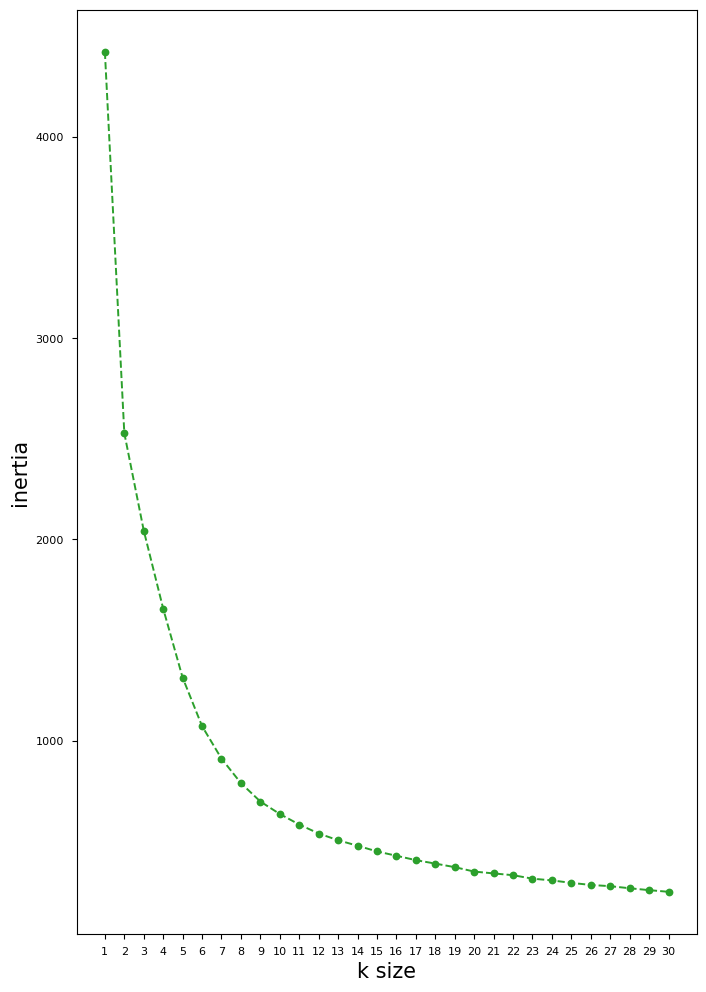

In [9]:
# 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.clf()
plt.style.use('default')
plt.style.use('seaborn-paper')

xpos = np.array(range(1,31))
fig = plt.figure(figsize=(8, 12))
plt.plot(xpos, inertia, marker='o', linestyle='--', color='#2ca02c')
plt.xlabel("k size", fontsize=15)
plt.xticks(xpos, xpos)
plt.ylabel("inertia", fontsize=15)
plt.show()

### Silhouette Score
: 값이 높으면 객체가 자체 클러스터와 잘 일치하고 인접 클러스터와 잘 일치하지 않음을 나타냄
- 참고: https://nicola-ml.tistory.com/66

In [11]:
from sklearn.metrics import silhouette_score
import seaborn as sns
def visualize_silhouette_layer(data, param_init='k-means++', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,40)
    results = []

    for i in clusters_range:
        clusterer = km(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")
    return pivot_km

pivot_km = visualize_silhouette_layer(exploit_embedding_list)

<Figure size 640x440 with 0 Axes>

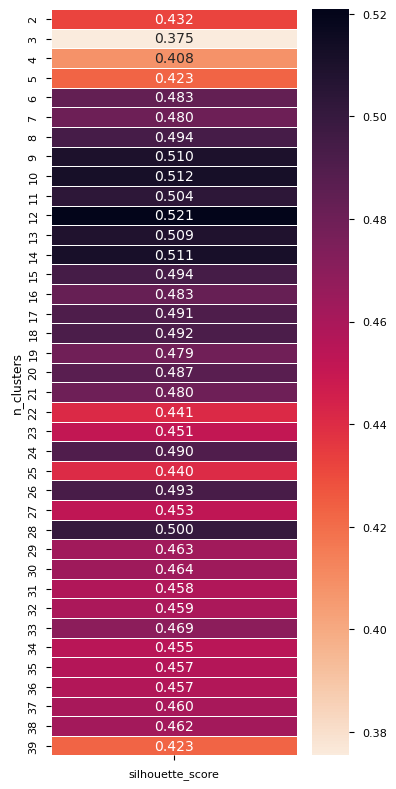

In [12]:
sns.reset_orig()
plt.clf()
fig = plt.figure(figsize=(4, 8))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()
plt.show()

분석 결과: 11~14 에서 가장 좋은 clustering이 발생

### K-mean Unsupervised learning

In [13]:
def unsupervised_learning(data, n): # n = k 수
    # cluster 개수 -> km_model.inertia_ 를 보면 기울기 변화가 적어지는 부분이 20
    km_model = km(n_clusters = n, algorithm = 'full', init='k-means++')
    km_model.fit(data)    # 학습
    predict_list = km_model.predict(data)    # clustering
    return predict_list

In [14]:
km_label = unsupervised_learning(exploit_embedding_list,14)
exploit['km_label'] = km_label
exploit

EID   PATH_NUM                                       SYSCALL_PATH  \
0     10613  exit_code                                           [102, 1]   
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
2     10613  exit_code                                           [102, 1]   
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]   
...     ...        ...                                                ...   
4076   9545       main                                  [102, 104, 9, 41]   
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]   
4078   9545       main                                      [102, 104, 9]   
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   

      km_label  
0            1  
1            4  
2            1  
3            4  
4            4  
...        ...  
4076        10  
4077         4  
4078         4  
4079        11  
4080        11  

[3942 rows x 4 columns]

Text(0.5, 1.0, 'PCA Transformed')

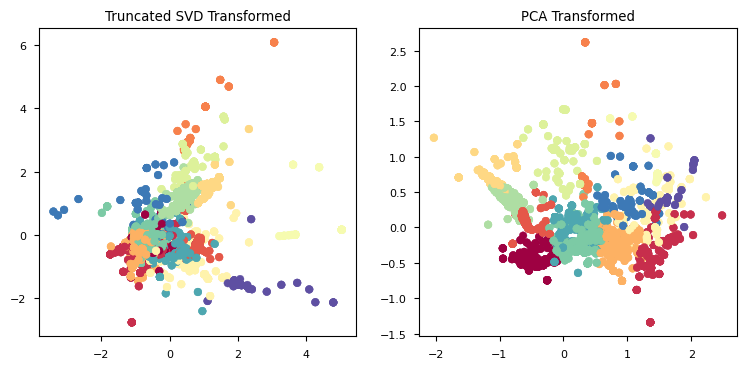

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA


# 특이값 분해
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(exploit_embedding_list)
scaler = StandardScaler() # exploit 데이터를 StandardScaler로 변환
exploit_tsvd = scaler.fit_transform(exploit_embedding_list)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(exploit_embedding_list)
exploit_pca = pca.transform(exploit_embedding_list)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=exploit_tsvd[:,0], y= exploit_tsvd[:,1], c= exploit.km_label, cmap='Spectral')
ax2.scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= exploit.km_label, cmap='Spectral')
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [16]:
pca = PCA(n_components=3)
components = pca.fit_transform(exploit_embedding_list)

total_var = pca.explained_variance_ratio_.sum() * 100
import plotly.express as px
fig = px.colors.qualitative.swatches()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=exploit.km_label,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.show()

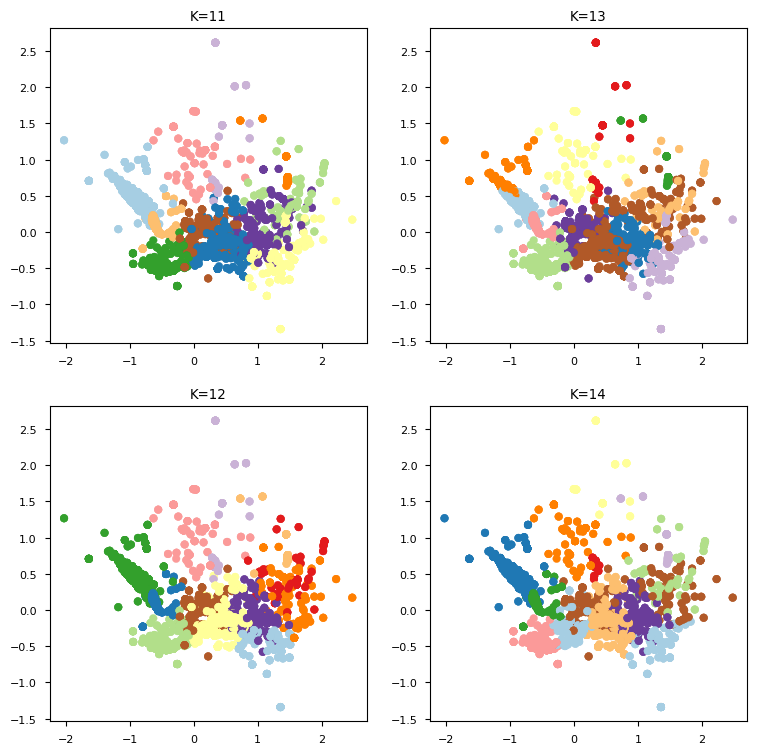

In [17]:
fig, ax = plt.subplots(figsize=(9,9),ncols=2, nrows=2)
j=0
plot_list = [11,12,13,14]
for i, k in enumerate(plot_list):
    km_label = unsupervised_learning(exploit_embedding_list,k)
    # TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
    ax[i%2][j].scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= km_label, cmap='Paired')
    ax[i%2][j].set_title(f'K={k}')
    if i == 1:
        j = 1

# 같은 그룹 끼리 Cosine 유사도 비교

In [18]:
k_label = len(set(exploit.km_label))
print("K-Mean++ label 수: ", len(set(exploit.km_label)))

K-Mean++ label 수:  14


In [19]:
same_cluster_exploit = set()
cluster_exploits = list()
for label in range(k_label):
    for idx in exploit[exploit['km_label'] == label].index:
        same_cluster_exploit.add(exploit.loc[idx].EID)
    cluster_exploits.append(same_cluster_exploit.copy())
    same_cluster_exploit = set()

In [20]:
# 익스플로잇 기준 속한 그룹
all_exploits = list(set(exploit['EID']))
for eid in all_exploits:
    print(eid, set(exploit[exploit['EID'] == eid]['km_label'].values)-{0})

9479 {10, 4}
4756 {11, 12, 6}
41994 {1, 4, 5, 8, 10, 11}
8673 {4, 13, 6}
10613 {1, 4}
33516 {1, 10}
40812 {1, 10, 11}
37183 {11}
27297 {10}
47170 {1, 2, 4, 5, 6, 8, 10, 11}
9575 {11}
40871 {1, 2, 4, 5, 6, 8, 10, 11, 13}
5093 {1, 4}
31347 {2, 11, 4, 12}
44302 {11, 2, 10, 6}
24746 {8, 2, 11, 5}
9542 {10, 12, 4}
15285 {3, 4, 5, 6, 12}
43345 {2, 12}
43418 {2, 4, 5, 8, 10, 11}
43029 {1, 11, 4}
47163 {1, 4, 5, 6, 10, 11, 13}
9083 {1, 4, 5, 6, 8, 9, 10, 11, 12}
26131 {1, 4, 6, 10, 11, 12}
17391 {4, 5, 8, 10, 12}
40839 {11, 10, 3, 6}
895 {11, 4, 12}
35161 {4, 6, 10, 12, 13}
25450 {10, 11, 4}
37292 {11, 4, 6}
47168 {1, 2, 4, 5, 8, 10, 11}
39166 {11, 4, 6}
34923 {1, 2, 4, 6, 9}
2005 {4, 12, 6}
5092 {1, 10, 4}
25202 {3, 12}
22363 {11, 6}
15944 {10, 11}
1397 {1, 3, 10, 11, 12}
33321 {4}
35370 {2, 4, 5, 6, 8, 11}
44299 {8, 1, 11, 5}
15774 {10}
39230 {1, 4}
926 {10, 11, 4}
17787 {1, 10, 11, 4}
37722 {12}
8678 {11, 4, 13, 6}
18411 {4, 5, 8, 10, 11}
30604 {11, 6}
24555 {10, 12}
6851 {10}
2013 {10, 11,

In [38]:
# def get_features(words, model, num_features):
#     # 출력 벡터 초기화
#     feature_vector = np.zeros((num_features), dtype=np.float32)
    
#     num_words = 0
#     # 어휘 사전 준비
#     index2word_set = set(model.wv.index2word)
    
#     for w in words:
#         if w in index2word_set:
#             num_words = 1
#             # 사전에 해당하는 단어에 대해 단어 벡터를 더함
#             feature_vector = np.add(feature_vector, model[w])
            
#     # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
#     feature_vector = np.divide(feature_vector, num_words)
#     return feature_vector
# get_features(all_dictionary, km_model, 4)
type(km_model)

AttributeError: 'KMeans' object has no attribute 'feature_names_in_ndarray'

In [27]:
# 클러스터 간의 핵심 단어 추출
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['label']==cluster_num]['EID']
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['EID'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['EID'][:5]}")
        print('-'*20)

cluster_details = get_cluster_details(cluster_model=km_model,
                                     cluster_data=exploit_embedding_list,
                                     feature_names=all,
                                     cluster_num=k_label,
                                     top_n_features=10)
print_cluster_details(cluster_details)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [21]:
# 그룹 기준 속한 익스플로잇 
all_exploits = list(set(exploit['EID']))
cluster_exploits = list()
for label in range(k_label):
    cluster_exploits.append(list(set(exploit[exploit['km_label'] == label]['EID'])))
for cluster in cluster_exploits:
    print(cluster)

['6851', '50808', '15916', '40003', '41994', '25288', '33516', '40616', '1397', '44303', '47170', '33336', '35370', '42887', '15774', '44302', '5093', '47169', '14814', '15704', '15285', '43418', '43029', '9083', '12', '37167', '17787', '45553', '20979', '15023', '17391', '40839', '895', '20000', '44300', '47168', '37722', '15024', '40049']
['41458', '50808', '40003', '41994', '10613', '718', '33516', '40812', '38390', '1397', '44303', '47170', '50135', '44299', '50541', '40871', '5093', '39230', '33824', '44298', '33322', '43029', '47163', '9083', '3', '45010', '17787', '45553', '32751', '26131', '39277', '47168', '34923', '5092', '41995']
['47170', '15916', '43345', '43418', '33336', '35370', '47168', '47169', '40871', '31347', '44302', '34923', '24746', '40616', '45553', '41995']
['25202', '40839', '50135', '41458', '1397', '15285']
['41458', '50808', '9479', '2013', '41994', '25288', '8673', '10613', '38390', '47170', '15024', '33321', '35370', '42887', '50541', '40871', '5093', '3

In [22]:
# EID: Syscall Path 형태로 만들어주기 (기존의 Syscall_Path 모두 붇이기)
exploit_only_one_path = pd.DataFrame( columns = {'EID','SYSCALL_PATH'})
new_data = {"EID":"", "SYSCALL_PATH": list()}
concat_path = list()
for idx in df.index:
    if idx == 0:
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
    if not df.loc[idx,'EID'] == new_data["EID"]:
        exploit_only_one_path = exploit_only_one_path.append(new_data, ignore_index=True)
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
        new_data["EID"] = df.loc[idx,'EID']
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
    else:
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
exploit_only_one_path

EID                                       SYSCALL_PATH
0    10613  [102, 1, 102, 1, 102, 1, 12, 12, 1, 59, 102, 1...
1       12  [101, 101, 101, 101, 101, 101, 101, 101, 101, ...
2     1397  [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
3    14814  [12, 12, 257, 12, 12, 257, 5, 0, 5, 0, 5, 0, 3...
4    15023  [12, 12, 257, 12, 12, 257, 5, 0, 5, 0, 5, 0, 3...
..     ...                                                ...
96    9083  [3, 3, 3, 3, 3, 3, 3, 3, 3, 203, 203, 12, 12, ...
97     926  [13, 13, 14, 9, 14, 56, 11, 14, 61, 13, 13, 14...
98    9479  [102, 104, 135, 10, 257, 41, 40, 3, 41, 102, 4...
99    9542  [102, 104, 135, 9, 41, 44, 44, 102, 102, 104, ...
100   9545  [102, 104, 9, 41, 87, 77, 102, 104, 9, 41, 87,...

[101 rows x 2 columns]

In [23]:
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

exploit_only_one_path_embedding_list = get_exploit_vectors(exploit_only_one_path['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_only_one_path_embedding_list))

/tmp/ipykernel_2480927/167459078.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2480927/167459078.py:16: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 101


In [24]:
from sklearn.metrics.pairwise import cosine_similarity
sim_df = list()
exploit_cosine_similarities = list()
sim_exploit_list = list()
xyticklabels = list()
for i, exploits in enumerate(cluster_exploits):
    for eid in exploits:
        if len(exploit_only_one_path[exploit_only_one_path['EID']==eid].index) > 0:
            idx = exploit_only_one_path[exploit_only_one_path['EID']==eid].index[0]
            sim_df.append(exploit_only_one_path_embedding_list[idx])
            sim_exploit_list.append(exploit_only_one_path.loc[idx].EID)
        
    exploit_cosine_similarities.append( cosine_similarity( sim_df, sim_df))
    print(f'Label {i} 코사인 유사도 매트릭스의 크기 :',exploit_cosine_similarities[i].shape)
    sim_df = []
    xyticklabels.append(sim_exploit_list.copy())
    sim_exploit_list = []

Label 0 코사인 유사도 매트릭스의 크기 : (39, 39)
Label 1 코사인 유사도 매트릭스의 크기 : (35, 35)
Label 2 코사인 유사도 매트릭스의 크기 : (16, 16)
Label 3 코사인 유사도 매트릭스의 크기 : (6, 6)
Label 4 코사인 유사도 매트릭스의 크기 : (51, 51)
Label 5 코사인 유사도 매트릭스의 크기 : (19, 19)
Label 6 코사인 유사도 매트릭스의 크기 : (33, 33)
Label 7 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 8 코사인 유사도 매트릭스의 크기 : (17, 17)
Label 9 코사인 유사도 매트릭스의 크기 : (6, 6)
Label 10 코사인 유사도 매트릭스의 크기 : (49, 49)
Label 11 코사인 유사도 매트릭스의 크기 : (54, 54)
Label 12 코사인 유사도 매트릭스의 크기 : (23, 23)
Label 13 코사인 유사도 매트릭스의 크기 : (12, 12)


<Figure size 640x440 with 0 Axes>

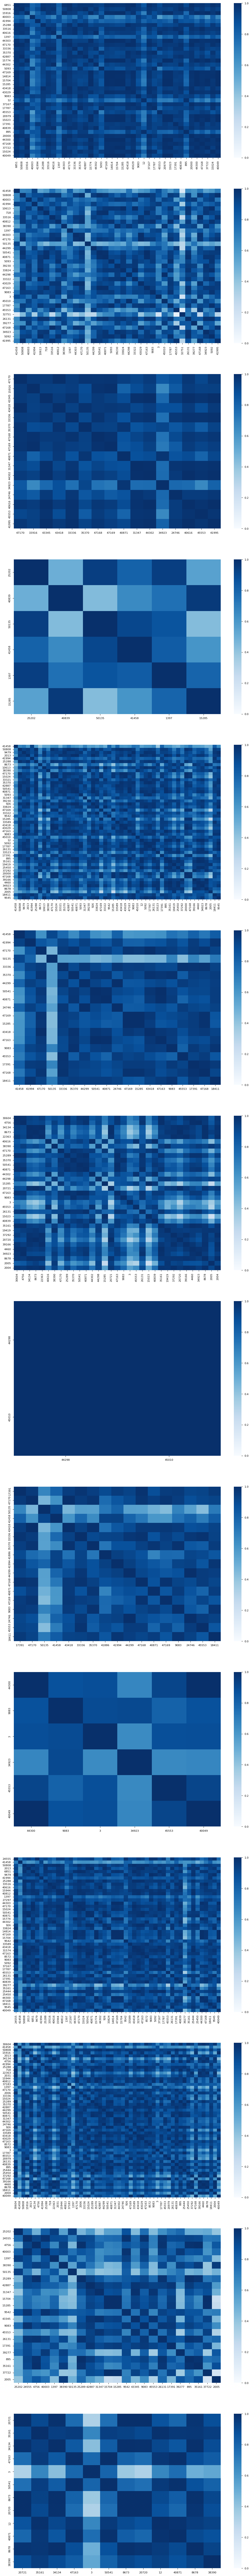

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_orig()
plt.clf()
figure, ax = plt.subplots(nrows = k_label, ncols =1 )
figure.set_size_inches(k_label,k_label*10)


for i in range(k_label):
    sns.heatmap(exploit_cosine_similarities[i], xticklabels= xyticklabels[i], yticklabels= xyticklabels[i], cmap='Blues', vmin=0, vmax=1, annot=False, ax = ax[i])
